In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as sp

In [2]:
df = pd.read_csv('FleetAll.csv')
df=df.drop(columns=['Vehicle Category','GVWR Class','MPO'])
df = df.where(df['Model Year'] != 'Unknown').dropna()

In [3]:
years = np.arange(2018,2036)
years_missing=[2018, 2019, 2020, 2021, 2022, 2026, 2027, 2028,
       2029, 2030, 2031, 2032, 2033, 2034, 2035]
sales_percentage_missing = [7.6,7.6,8.1,12.8,17.9,35,43,51,59,68,76,82,88,94,100]
f= sp.interp1d(years_missing,sales_percentage_missing)
sales_percentage = []
for i in years:
    sales_percentage.append(f(i))


In [4]:
times = df.drop(columns=['Fuel Type'])
times = times.where(times['Model Year'] != 'Unknown').dropna()
times['Model Year'] = times['Model Year'].astype(int)
times = times.groupby(['Model Year']).sum()

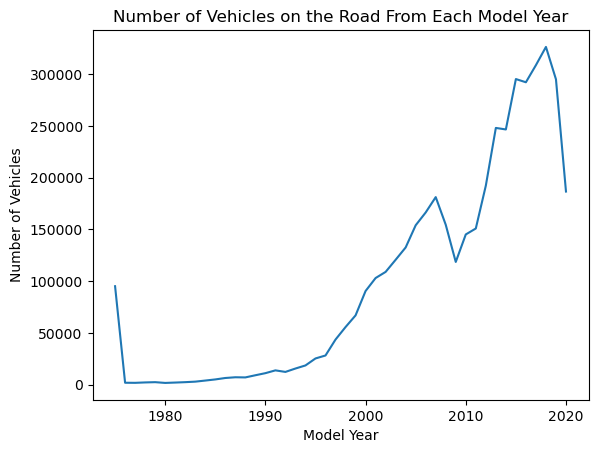

In [5]:
shortened = times.drop(2021, axis = 0)
plt.plot(shortened)
plt.ylabel('Number of Vehicles')
plt.xlabel('Model Year')
plt.title('Number of Vehicles on the Road From Each Model Year')
plt.show()

In [6]:
f2 = sp.CubicSpline([1980,1990,2002,2015,2018],np.log([1801,11219.0,108976.0-8000,295129.0-10050,326147.0-20000]), extrapolate=True)

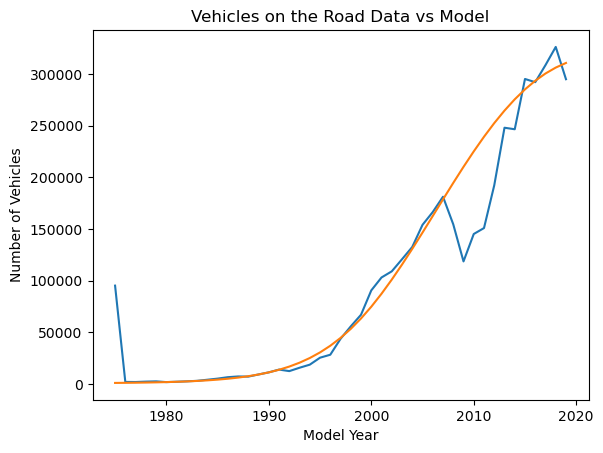

In [7]:
plt.figure()
plt.plot(np.arange(1975,2020),times['Vehicle Population'][np.arange(1975,2020)])
plt.plot(np.arange(1975,2020),np.exp(f2(np.arange(1975,2020))))
plt.ylabel('Number of Vehicles')
plt.xlabel('Model Year')
plt.title('Vehicles on the Road Data vs Model')
plt.show()

In [8]:
def model(year):
    return 0.98323* np.exp(f2(year))

In [9]:
pops = np.array(times['Vehicle Population'])
weighted_avg_tot = 0
for i in range(47):
    weighted_avg_tot += pops[i]*(1975+i)

weighted_avg = weighted_avg_tot/sum(pops)
weighted_avg

2009.83158810058

In [10]:
weighted_model_tot = 0
for i in range(1960,2020):
    weighted_model_tot += model(i)*(i)

weighted_model = weighted_model_tot/sum(pops)
weighted_model

2009.8276601936905

In [11]:
evf = df.where(df['Fuel Type'] == 'Electric').dropna()
evf = evf.where(evf['Model Year'] != 'Unknown').dropna()
evf = evf.drop('Fuel Type', axis = 1)
evf = evf.groupby(['Model Year']).sum()

icef = df.where(df['Fuel Type'] == 'Gasoline').dropna()
icef = icef.where(icef['Model Year'] != 'Unknown').dropna()
icef = icef.drop('Fuel Type', axis = 1)
icef = icef.groupby(['Model Year']).sum()


icef = icef.rename(columns={"Vehicle Population": "ICE Population"})
evf = evf.rename(columns={"Vehicle Population": "EV Population"})
dfn = icef.merge(evf, how = 'outer',on='Model Year')
dfn = dfn.fillna(0)

In [23]:
total_years = np.array(range(1975,2051))
EV_percent = np.array(dfn["EV Population"]/(dfn["EV Population"]+dfn["ICE Population"]))
EV_percent = np.append(EV_percent,sales_percentage[4:])
EV_percent_2 = np.append(EV_percent, (np.ones(15)*100))
percents = pd.DataFrame(data = {'total_years': total_years, 'EV_percent': EV_percent_2})

In [22]:
percents

,total_years,EV_percent
0,1975,0.000084
1,1976,0.000516
2,1977,0.000546
3,1978,0.000000
4,1979,0.000000
...,...,...
71,2046,100.000000
72,2047,100.000000
73,2048,100.000000
74,2049,100.000000


15

In [32]:
pred_pop = []
pred_EV = []
for i in range(1960,2020):
    pred_pop.append(model(i))
    pred_EV.append(model(i)*(percents.iloc[i-1960,1])/100)
sum(pred_EV)

1882584.8713741102

In [26]:
EV_percent_2

array([8.41874855e-05, 5.16262261e-04, 5.45851528e-04, 0.00000000e+00,
       0.00000000e+00, 1.88205772e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.08778418e-04, 0.00000000e+00,
       0.00000000e+00, 8.05996615e-05, 6.37795778e-04, 5.35848248e-05,
       3.94788788e-05, 1.41758514e-04, 4.58694555e-05, 1.25890224e-04,
       4.18816842e-04, 2.65389847e-04, 5.82835495e-05, 4.69051780e-04,
       1.16378630e-04, 2.26560435e-05, 1.30219355e-05, 1.20441297e-05,
       6.62716142e-05, 7.70960072e-04, 1.35306554e-04, 6.63015477e-04,
       7.69492589e-03, 8.48272618e-03, 1.85945140e-02, 2.00324162e-02,
       2.28092797e-02, 3.15598989e-02, 4.87193800e-02, 1.15418984e-01,
       9.72044601e-02, 1.11751554e-01, 2.46275464e-02, 1.79000000e+01,
       2.21750000e+01, 2.64500000e+01, 3.07250000e+01, 3.50000000e+01,
       4.30000000e+01, 5.10000000e+01, 5.90000000e+01, 6.80000000e+01,
      

In [37]:
pred_EV = []
for i in range(0,60):
    pred_EV.append(pred_pop[i]*(EV_percent_2[i])/100)

In [38]:
def evp_year(year):
    cut = year - 2035
    p= EV_percent_2[cut:]
    pred_EV = []
    for i in range(0,60):
        pred_EV.append(pred_pop[i]*(p[i])/100)
    return sum(pred_EV)/sum(pred_pop)

In [39]:
evp_year(2035)

0.4217366135393132

In [43]:
type(x)

range

In [46]:
x=np.arange(2035,2051)
y=[]
for i in x:
    y.append(evp_year(i))


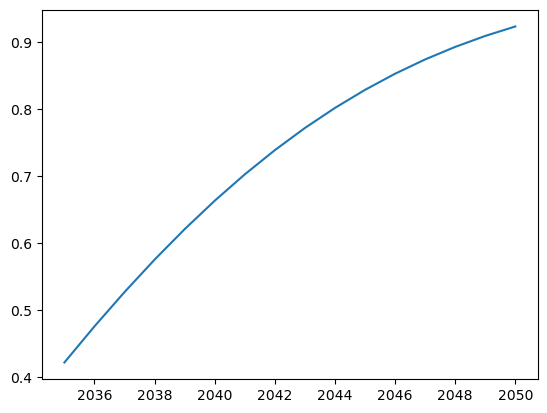

In [47]:

plt.plot(x,y)

In [14]:
sum(pred_EV)/sum(pred_pop)

0.4217366135393132

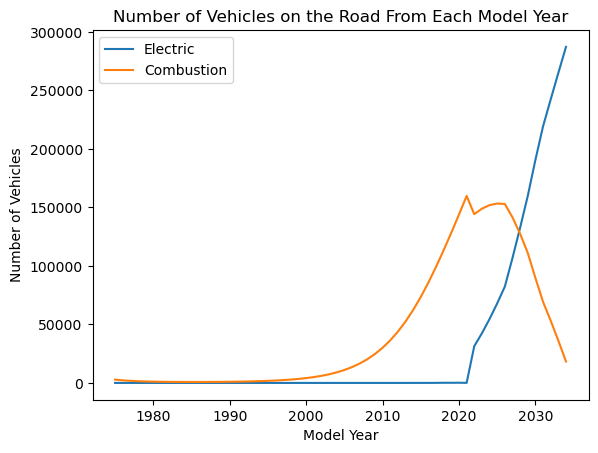

In [15]:
plt.figure()
plt.plot(np.arange(1975,2035),pred_EV)
#plt.plot(np.arange(1975,2035),pred_pop)
plt.plot(np.arange(1975,2035),np.subtract(pred_pop,pred_EV))
plt.ylabel('Number of Vehicles')
plt.xlabel('Model Year')
plt.title('Number of Vehicles on the Road From Each Model Year')
plt.legend(['Electric', 'Combustion'])
plt.show()

In [31]:
pred_EV_high = [0.00036006396365306954,
 0.002133410501095572,
 0.0022110412221507053,
 0.0,
 0.0,
 0.00778825468366599,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0008890286626737423,
 0.0,
 0.0,
 0.0009708105083732462,
 0.008861995374740951,
 0.0008640428650709894,
 0.0007428173820362347,
 0.0031279195072511107,
 0.001192256711759168,
 0.003870025201839624,
 0.01528067568311609,
 0.011526716324547446,
 0.003021075917015163,
 0.029074178748757985,
 0.008639583759436876,
 0.002016432403448333,
 0.001390232612428164,
 0.0015424717743377698,
 0.010176582697180052,
 0.14181653781372167,
 0.02977197012598183,
 0.17416646815008338,
 2.4073601036949652,
 3.151349858705109,
 8.174940282109016,
 10.38175845600693,
 13.87303367085889,
 22.417512990486067,
 40.19762749159579,
 109.97132702885048,
 106.29600404823101,
 139.35504433755096,
 34.78751254861118,
 28442.513460591763,
 39350.99891416536,
 52028.86569178274,
 66476.99123400262,
 82628.0301990795,
 109852.94109647052,
 139793.23328183786,
 171994.46251468823,
 208918.28897091068,
 243797.76841497232,
 272023.8231722502,
 298927.5606591791,
 323667.77212164825]
pred_EV_low = [5.79609563824262e-09,
 8.614653843864945e-08,
 2.1389202139570504e-07,
 0.0,
 0.0,
 7.947725086245942e-06,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00012658704669283246,
 0.0,
 0.0,
 0.00038891285924278575,
 0.004727048832617151,
 0.0005970642495871365,
 0.0006476727397892218,
 0.0033554562338538596,
 0.0015360204615281958,
 0.005851336790133388,
 0.026524969809589915,
 0.022496763302210347,
 0.0064995504652095295,
 0.06767303212541359,
 0.021376708986059055,
 0.0052167375010571245,
 0.003703152704379183,
 0.004170094014425332,
 0.027556546824130765,
 0.3799861322676123,
 0.07806644690837355,
 0.44249603289658085,
 5.8738116575047545,
 7.327062926334788,
 17.99146591639005,
 21.506510872859675,
 26.92961015207001,
 40.63705752769528,
 67.88942790287773,
 172.8078299879099,
 155.28342755590364,
 189.17958636890904,
 43.88486255010184,
 33355.9029082804,
 42936.300166908426,
 52881.68708214878,
 63041.93538837746,
 73259.70479133748,
 91282.71988974647,
 109178.94172568034,
 126665.09817425253,
 145612.89705112614,
 161473.88617728016,
 171978.51718191992,
 181280.29457112783,
 189278.53367150418]
pred_ice_low = [6.88474151e-03, 1.66864983e-02, 3.91848044e-02, 8.92082710e-02,
       1.97007140e-01, 4.22281179e-01, 8.79120139e-01, 1.77850983e+00,
       3.49859225e+00, 6.69605051e+00, 1.24764708e+01, 2.26449695e+01,
       4.00606500e+01, 6.91177858e+01, 1.16371345e+02, 1.91314301e+02,
       3.07292423e+02, 4.82523796e+02, 7.41149259e+02, 1.11424071e+03,
       1.64055440e+03, 2.36701936e+03, 3.34867667e+03, 4.64796173e+03,
       6.33328368e+03, 8.47685165e+03, 1.11515972e+04, 1.44275574e+04,
       1.83682212e+04, 2.30258047e+04, 2.84378020e+04, 3.46234524e+04,
       4.15811941e+04, 4.92870145e+04, 5.76959054e+04, 6.67394826e+04,
       7.63276964e+04, 8.63689483e+04, 9.67388579e+04, 1.07337040e+05,
       1.18037343e+05, 1.28721048e+05, 1.39280000e+05, 1.49549382e+05,
       1.59593999e+05, 1.69096687e+05, 1.78150329e+05, 1.52989923e+05,
       1.50688503e+05, 1.47049077e+05, 1.42139303e+05, 1.36053737e+05,
       1.21002675e+05, 1.04897415e+05, 8.80215089e+04, 6.85237163e+04,
       5.09917535e+04, 3.77513818e+04, 2.47200402e+04, 1.20816085e+04]
pred_ice_high = [   427.69261756,    413.23948065,    405.06054086,    402.59846299,
          405.54464771,    413.80814394,    427.52638846,    446.98303949,
          472.6903933 ,    505.36520263,    545.96139508,    595.70574678,
          656.14543785,    729.20916775,    817.28316057,    923.31105766,
         1050.9023778 ,   1204.48362693,   1389.46339281,   1612.47593075,
         1881.55568588,   2206.50949048,   2599.23766505,   3074.12300602,
         3648.51890788,   4343.30321236,   5183.40798354,   6198.47181867,
         7423.67712834,   8900.19454032,  10676.08142202,  12806.8331055 ,
        15355.85947947,  18394.65487351,  22003.31689926,  26268.66481567,
        31282.62564749,  37147.05003437,  43956.08396642,  51814.41227106,
        60808.01117265,  71009.21999263,  82468.29793766,  95170.13202316,
       109246.71509134, 124561.41184025, 141219.69245336, 130454.20978294,
       138105.59145411, 144677.6208556 , 149884.24956015, 153452.056084  ,
       145619.01494183, 134311.14570216, 119521.5756458 ,  98314.48892749,
        76988.76897315,  59712.54655001,  40762.8491808 ,  20659.64502904]

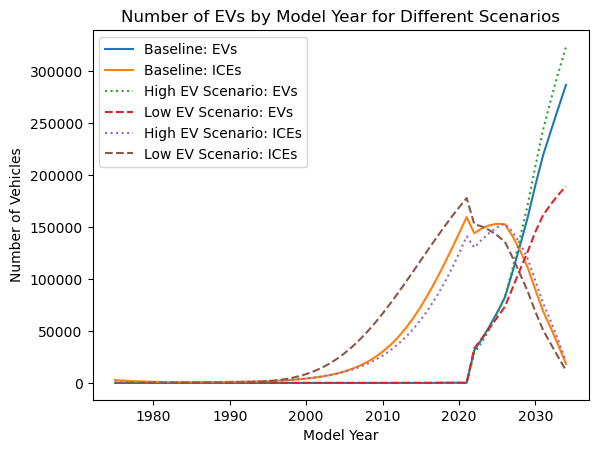

In [35]:
plt.figure()
plt.plot(np.arange(1975,2035),pred_EV,'-')
plt.plot(np.arange(1975,2035),np.subtract(pred_pop,pred_EV),'-')
plt.plot(np.arange(1975,2035),pred_EV_high,':')
plt.plot(np.arange(1975,2035),pred_EV_low,'--')
plt.plot(np.arange(1975,2035),pred_ice_high,':')
plt.plot(np.arange(1975,2035),pred_ice_low,'--')
#plt.plot(np.arange(1975,2035),pred_pop)

plt.ylabel('Number of Vehicles')
plt.xlabel('Model Year')
plt.title('Number of EVs by Model Year for Different Scenarios')
plt.legend(['Baseline: EVs', 'Baseline: ICEs', 'High EV Scenario: EVs', 'Low EV Scenario: EVs', 'High EV Scenario: ICEs', 'Low EV Scenario: ICEs'])
plt.show()

In [16]:
pred_ice = np.array(pred_pop)-np.array(pred_EV)

In [17]:
gf = pd.read_excel('gasoline_data.xlsx')

In [18]:
gf = gf.groupby(["Model Year"]).sum()

In [19]:
gf

,Calendar Year,Population,Total VMT,CVMT,EVMT,Trips,Energy Consumption,NOx_RUNEX,NOx_IDLEX,NOx_STREX,...,CO_RUNEX,CO_IDLEX,CO_STREX,CO_TOTEX,SOx_RUNEX,SOx_IDLEX,SOx_STREX,SOx_TOTEX,NH3_RUNEX,Fuel Consumption
Model Year,,,,,,,,,,,,,,,,,,,,,
1991.0,73260.0,4113.512630,2.537713e+04,2.537713e+04,0.0,1.065175e+04,0.0,0.037970,0.0,0.013270,...,0.329631,0.0,0.335137,0.664768,0.000115,0.0,0.000016,0.000131,0.001926,1.398923
1992.0,73260.0,3493.719104,2.250823e+04,2.250823e+04,0.0,9.174151e+03,0.0,0.033720,0.0,0.011390,...,0.294617,0.0,0.286043,0.580660,0.000102,0.0,0.000014,0.000116,0.001703,1.236456
1993.0,73260.0,3885.529160,2.737439e+04,2.737439e+04,0.0,1.042117e+04,0.0,0.041936,0.0,0.013340,...,0.341548,0.0,0.317821,0.659369,0.000116,0.0,0.000015,0.000131,0.002074,1.399861
1994.0,73260.0,4196.844214,3.168180e+04,3.168180e+04,0.0,1.152232e+04,0.0,0.045192,0.0,0.014609,...,0.369983,0.0,0.334657,0.704640,0.000133,0.0,0.000017,0.000150,0.002406,1.597180
1995.0,73260.0,5115.816343,4.048089e+04,4.048089e+04,0.0,1.435731e+04,0.0,0.052240,0.0,0.017349,...,0.453885,0.0,0.410201,0.864085,0.000171,0.0,0.000021,0.000192,0.003079,2.044681
1996.0,73260.0,5170.434497,4.317127e+04,4.317127e+04,0.0,1.467536e+04,0.0,0.060159,0.0,0.023333,...,0.527765,0.0,0.399568,0.927333,0.000183,0.0,0.000021,0.000205,0.003273,2.181978
1997.0,73260.0,6869.199014,6.420114e+04,6.420114e+04,0.0,2.010561e+04,0.0,0.076274,0.0,0.032554,...,0.613499,0.0,0.452561,1.066061,0.000276,0.0,0.000028,0.000304,0.004897,3.242379
1998.0,73260.0,7923.902643,7.800771e+04,7.800771e+04,0.0,2.355551e+04,0.0,0.076765,0.0,0.037041,...,0.590526,0.0,0.422553,1.013079,0.000333,0.0,0.000030,0.000363,0.003824,3.868344
1999.0,73260.0,8516.698109,8.632089e+04,8.632089e+04,0.0,2.554611e+04,0.0,0.071127,0.0,0.040685,...,0.497416,0.0,0.350596,0.848012,0.000368,0.0,0.000030,0.000398,0.004218,4.244895


In [20]:
pred_ice = np.array(pred_pop)-np.array(pred_EV)
first15 = pred_ice[0:16]
s=sum(first15)
print(s)
pred_ice = pred_ice[15:60]
pred_ice[0] = s
len(pred_ice)

19460.71968331677


45

In [21]:
tvmt = gf["Total VMT"]
sum(tvmt)

135746176.53382397

In [22]:
my_total_vmt = 95734591
mtv = sum(pred_ice)
a = my_total_vmt/mtv
mvmt = pred_ice*a
mvmt

array([ 721753.3861817 ,   40102.10006334,   44505.0662842 ,
         50058.41801295,   57010.03027119,   65674.77530228,
         76453.11522311,   89849.67963705,  106496.45081875,
        127181.79587203,  152884.33046075,  184808.36284508,
        224425.44360844,  273523.41839426,  334240.11523726,
        409109.1055261 ,  501084.17385055,  613545.98051336,
        750274.12805381,  915402.34800247, 1113234.14591625,
       1348013.9553163 , 1623921.83387883, 1944040.11514451,
       2310824.63969088, 2724463.88235535, 3182741.78883643,
       3680370.83006908, 4207735.89624886, 4763636.70945539,
       5336225.98165789, 5925202.59223914, 5347599.91190911,
       5521274.75011226, 5634948.77311085, 5685087.6508668 ,
       5669924.49746932, 5246572.76476687, 4726625.25651345,
       4118074.49639903, 3326597.51868232, 2567851.07726369,
       1971929.85592773, 1339665.2996433 ,  679644.55236769])

In [23]:
sum(gf["Fuel Consumption"])

4099.213718826676

In [24]:
np.array(gf["Fuel Consumption"]*(mvmt/tvmt))

array([ 39.78690432,   2.20294909,   2.27588264,   2.52360456,
         2.87956351,   3.31935862,   3.86114618,   4.4555786 ,
         5.2370439 ,   6.38401998,   7.61288761,   9.19720548,
        11.16090453,  13.50193825,  16.13700749,  19.47040003,
        23.2675703 ,  28.24229962,  31.91156518,  36.66228934,
        45.66027162,  52.10256847,  61.26178826,  73.19614658,
        85.55719152,  98.9657673 , 116.65189885, 135.76291631,
       151.2706987 , 166.76990776, 178.93559062, 191.75622531,
       166.85392975, 165.98837136, 163.01013864, 162.42970818,
       161.68753523, 149.38046999, 134.33486179, 116.83275689,
        94.23753551,  72.68539215,  55.77801325,  37.87931274,
        19.22378285])

In [25]:
4099*96/135

2914.8444444444444

In [26]:
214/3128

0.06841432225063938